In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from matplotlib.colors import ListedColormap
from IPython.display import HTML
from IPython.display import Image

# Automatas Celulares y matríces de convolución

Un automata celular se puede describir como una cuadricula o rejilla de enteros, donde cada celula (cuadro) puede tomar un valor entre una cantidad $k$ de estados posibles. Cada célula se caracteriza por su vecindad de tal forma que la función de transición $f$, depende de la célula y su vecindad para actualizar su valor.

En este trabajo proponemos una nueva forma de obtener la transición de una generación a otro inspirada en el método de convolución, principalmente utilizado en el entrenamiento de redes neuronales (CNN).

Entonces consideremos una matriz $C$ de $3x3$, nuestro filtro o kernel, y una función $f:M_3(\mathbb{Z})\rightarrow\mathbb{Z}$, y sea $$AU_{ij} = a_{ij}$$ nuestro automata celular. Consideremos $a_{kl}$ una celula de nuestro automata y 
$$A_{kl} = \begin{bmatrix} a_{k-1j-1} & a_{k-1j} & a_{k-1,j+1} \\ a_{kj-1} & a_{kj} & a_{k,j+1} \\ a_{k+1j-1} & a_{k+1j} & a_{k+1,j+1} \end{bmatrix}$$  su vecindad cerrada, bajo el método de convolución su valor en la siguiente generación estará dado por $$f(CA_{kl})$$, como se muestra en el siguiente diagrama:


<img src="convolucion_2.png">


cuando nuestra célula se encuentre en el borde del automata tendrémos que agregar una frontera fantasma, que bien puede ser una frontera de ceros ('constant') o una frontera espejo o toro ('wrap'), para así poder aplicar el filtro.

### Motivación

La intención de utilizar el método propuesto es el poder aprovechar las herramientas de algebra lineal para el manejo de la matriz filtro y la facilidad de programar nuevas reglas de evolución.

Por otro lado, se buscará el aplicar metodos de aprendizaje para obtener, condicionado a cierta función de activación, los valores del filtro que llevan de una imagen a otra i.e. dados dos estados de un automata celular, encontrar el filtro respectivo a la regla que sigue.

A continuación se presenta el código de la clase AutomataCelular que incluye los metodos para obtener la transición de un estado a otro utilizando el método propuesto.

In [2]:
class AutomataCelular:
    """ crea y actualiza un automata celular utilizando el metodo de convolución
        y una función de activación.
        
        ...
        
        Atributos
        ------------
        
        n: int
            dimensión del automata (cadricula)
        filtro: array(3,3) 
            matriz de convolución
        funcionActivacion: function
            función que recibé como parametro una matriz 3x3 y regresa un real
        frontera: str
            tipo de frontera para aplicar la convolución: 'constant' para ceros y 'wrap' para toro
            
        Metodos
        ------------
        
        evolucion()
            se actualiza el automata (una generación) utilizando el método de convolución
        
        generacionN(n = 1)
            se actualiza el automata (n generaciones) utilizando el método de convolución
            
        Notacion
        ------------
        AC = Automata celular
        ACM = Automata Celular Modificado (+ frontera)
        ACE = Automata Celular Evolución
        """
    
    def __init__(self, n, filtro, funcionActivacion, frontera = 'constant', ):
        self.AC = np.zeros((n,n))
        self.size = n
        self.filtro = filtro
        self.funcionActivacion = funcionActivacion
        self.frontera = frontera
      
    def evolucion(self):
        ACM = np.pad(self.AC, 1, mode = self.frontera)
        n = self.AC.shape [0]
        ACE = np.zeros(self.AC.shape)
        for i in range(n):
            for j in range(n):
                ACE[i,j] = self.funcionActivacion(self.filtro*ACM[i:i+3, j:j+3])
        self.AC = ACE
        
    def generacionN(self, n = 1):
        for i in range(n):
            self.evolucion()
            #plt.matshow(self.AC)  #descomentar en caso de no poder reproducir la animación
                                   #se imprimirán las generaciones

En el siguiente ejemplo se hará un primer acercamiento a un sistema parecido al juego de la vida pero probabilistico:

En el juego de la vida original, dada una célula viva esta seguirá viva si tiene dos o tres vecinos vivos, en caso contrario morirá, por otro lado, si la célula está muerta esta revivirá unicamente si tiene tres vecinos vivos. En este caso una vivo se representa con un 1 y muerto con un 0.

Para el caso probabilistico usaremos  como  filtro la matriz: $$\begin{bmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{bmatrix}$$

pues la traza del producto nos dará el número de vecinos superior-inferior-y-laterales.

Para simular el juego de la vida estocasticamente tomaremos en cuenta las siguientes condiciones:

> * Si la traza es cero o 1, la probabilidad de estar vivo será cero.
> * Si la traza es 2, la probabilidad de vivir será mayor a cero pero menor a 0.5.
> * Si la traza es 3, la probabilidad de vivir será cercana a uno.
> * Si la traza es 4, su modulo será cero por lo que la probabilidad de vivir será cero.

Para obtener estas probabilidades usaremos la función sigmoide (logística):
$$sigmoid(x,a,b) = \frac{1}{1+e^{a-bx}}$$ 
con parametros (21,10) pues sus valores se encuentran entre 0 y 1 y se cumplen las consideraciones anteriores:

<img src="sigmoid.png">

In [132]:
fil = np.matrix([[0,1,0],[1,0,1],[0,1,0]])


def sigmoid(X, a = 0, b = 1):
    return 1/(1+np.exp(a-b*X))

def funActivacion(M):
    return np.round(np.random.binomial(1, sigmoid(np.trace(M)%4, 20, 10.7), 1)[0]) #Al final lo cambié a a=20

#Colores a usar:
cmap = ListedColormap(['#CD853F', '#228B22'])

In [134]:
np.round(np.random.binomial(1, sigmoid(2%4, 20, 11), 1)[0])

1

## Tipo Constante

In [135]:
A = AutomataCelular(50, fil, funActivacion, frontera = 'constant')

A.AC = np.random.randint(2, size = A.AC.shape)

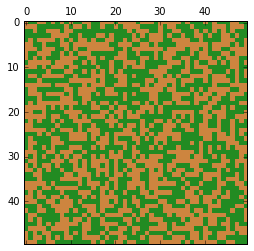

In [136]:
plt.matshow(A.AC, cmap = cmap)

In [139]:
%%capture

fig, ax = plt.subplots()
matrice = ax.matshow(A.AC, cmap = cmap)
plt.colorbar(matrice)

def update(i):
    A.evolucion()
    matrice.set_array(A.AC)
    return [matrice]

ani = animation.FuncAnimation(fig, update, frames=range(50), 
                              interval=200, blit=True)  #frames = range(numero de generaciones)

In [140]:
HTML(ani.to_html5_video())